In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.optimize import curve_fit

## Define Functions

In [2]:
## calculate cost of perturbation due to carbon
## input: temperature profile, perturbed temperature profile, total consumption, and discount function

def cost_of_perturbation(W, W_prime, discount_function, gamma=2, D0=0.00267):
    absolute_consumption_loss = W-W_prime
    discounted_consumption_loss = absolute_consumption_loss*discount_function
    area = simps(discounted_consumption_loss, dx=1)
    cost = area*10**12  # convert to dollar amount
    
    return cost

In [3]:
## calculate abatement given a carbon price

## default settings
P_50 = 300  # 187.5 * 0.7625000000000001
P_100 = 500  # 187.5
g_2019 = 0.02
g_grad = 0.0026  # 0.00034
W_2019 = 80
growth_adjustment = 0.015
consumption_discount = g_2019 + 0.015
s = 0.05
r = 0.03
P0_prime = 20

## test 
# P_100 = 287.5
# P_50 = P_100 * 0.528125
# g_2019 = 0.01
# g_grad = 0.0013  # g_grad = 0.0004
# W_2019 = 80
# growth_adjustment = 0.015
# consumption_discount = g_2019 + growth_adjustment
# constraint = 5  # param_values_2[i][1]
# r = consumption_discount
# s = r * np.log(constraint)/np.log((P_100)/(P_50))
# P0_prime = 31.33586359531034

    
# P_50 = 300  # 187.5 * 0.7625000000000001
# P_100 = 500  # 187.5
# g_2019 = 0.02
# g_grad = 0.0013 # 0.00034
# W_2019 = 80
# consumption_discount = g_2019 + 0.015
# s = 0.05
# r = 0.03
# P0_prime = 20
# # s = 0.1


def abatement(P, P0, P_50=P_50, r=r, s=s, P_100=P_100):  # 0.05
    if P0 >= P_50:
        print("P0 is greater than P_50")
    elif ((P_100-P0)/(P_50-P0))**(s/r) <= 2:
        print("MAC curve condition not satisfied")
    
    P_h = P0 + ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)
    Am = 1 + ((P_100 - P0) / (P_h - P0)) ** (-s / r)
    
    A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
    
    return A

In [4]:
## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

In [5]:
def create_W(W_2019, last_historical_year, start_year, T_forecast_years, g):
    W = []
    W_historical = [W_2019] * (last_historical_year - start_year + 1)
    W_forecast = []
    W_previous_year = W_historical[-1]

    for i in range(len(T_forecast_years) - 1):
        W_this_year = W_previous_year*np.exp(g[i])
        W_forecast.append(W_this_year)
        W_previous_year = W_this_year

    W = W_historical + W_forecast

    W = np.asarray(W)
    return W

# Steps outlined in Email

## 1. Create Unperturbed Temperature Profile

In [6]:
# get historical data (taken from chrisroadmap)

T_gas_df = pd.read_csv("T_gas.csv", index_col=0)

T_2019 = T_gas_df['CO2_best'][2019]

In [7]:
start_year = 1750
last_historical_year = 2019
end_year = 3000

years = np.arange(start_year, end_year+1)
T_forecast_years = np.arange(last_historical_year, end_year+1)
T_forecast_length = end_year - last_historical_year + 1

In [8]:
delta_T = 2
alpha = 0.02
T_forecast = T_2019 + delta_T * (1 - np.exp(-alpha*np.arange(T_forecast_length)))

In [9]:
T = np.concatenate([T_gas_df['CO2_best'],T_forecast[1:]])

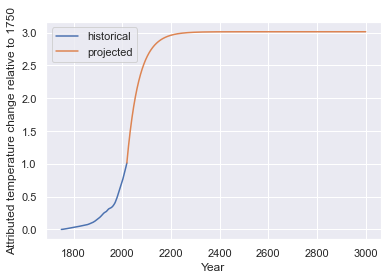

In [10]:
plt.plot(T_gas_df['CO2_best'], label="historical")
plt.plot(T_forecast_years, T_forecast, label="projected")
plt.xlabel("Year")
plt.ylabel("Attributed temperature change relative to 1750")
plt.legend()

## 2. Calculate SCC as a function of time for a range of years

In [11]:
## years to calculate SCC
first_perturbed_year = last_historical_year
last_perturbed_year = 2500
year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)


SCC_list = []
SCC_list_actual = []

for j in range(len(year_of_perturbation)):
    ## define perturbed temperature profile for a given year
    T_TCRE = 0.00054  # need to check this for FAIR!
    k_s = 0.12

    T_p = np.zeros(T_forecast_length)
    for i in range(len(T_forecast_years)):
        if year_of_perturbation[j] <= T_forecast_years[i]:
            T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))
    T_forecast_perturbed = T_forecast+T_p
    T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])
    

    g = g_2019 - g_grad*(T_forecast[:-1]-T_2019)**1
    g_prime = g_2019 - g_grad*(T_forecast_perturbed[:-1]-T_2019)**1
    
    growth_adjusted_consumption_discount = g[j] + growth_adjustment
    

    W = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g)
    W_prime = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g_prime)

    ## define discount function
    num_of_years = len(years)
    discount_function = np.zeros(num_of_years)


    for i in range(num_of_years):
        if years[i] >= year_of_perturbation[j]:
            discount_function[i] = np.exp(-growth_adjusted_consumption_discount*(years[i]-year_of_perturbation[j]))
    
    cost = cost_of_perturbation(W, W_prime, discount_function, gamma=2, D0=0.00267)
    SCC = cost/(10**9)
    SCC_list_actual.append(SCC)
    
    if j == 0 and P0_prime > P_100:
        print("P_100 achieved in first year")
        print(SCC)
    elif j == 0:  #  and SCC > P_100
        P0 = SCC
        SCC_adjusted = SCC - (P0-P0_prime)
        SCC_list.append(P0_prime)
    else:
        SCC_adjusted = SCC - (P0-P0_prime)
        if SCC_adjusted < P_100:
            SCC_list.append(SCC_adjusted)
        else:
            SCC_list.append(P_100)
            break

In [12]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

In [13]:
SCC_array

array([ 20.        ,  27.89729685,  35.95298728,  44.16431551,
        52.5378075 ,  61.0705519 ,  69.76929386,  78.63096395,
        87.66253516,  96.86077737, 106.23290036, 115.77551069,
       125.49606409, 135.39100114, 145.46803296, 155.72343136,
       166.16517257, 176.78935677, 187.60423522, 198.60573355,
       209.8023882 , 221.18994718, 232.77724254, 244.55984144,
       256.54688223, 268.73374786, 281.12989388, 293.73051549,
       306.54539662, 319.56954106, 332.81307245, 346.27079931,
       359.95319669, 373.85487374, 387.98666879, 402.3429874 ,
       416.93504329, 431.75703397, 446.82056101, 462.11960913,
       477.66618043, 493.45404192, 500.        ])

Text(0, 0.5, 'SCC ($)')

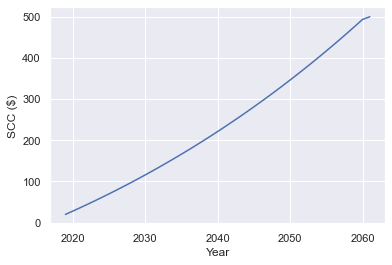

In [14]:
plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

### Check 100% abatement has been achieved!

In [15]:
if SCC_array[-1] < P_100:
    print("P_100 not achieved by achieved by final perturbed year")

In [16]:
SCC_forecasted = []

for i in range(T_forecast_length):
    if i < len(SCC_array):
        SCC_forecasted.append(SCC_array[i])
    else:
#         SCC_forecasted.append(SCC_array[-1])
        SCC_forecasted.append(P_100)

SCC_forecasted = np.array(SCC_forecasted)

In [17]:
# SCC_forecasted

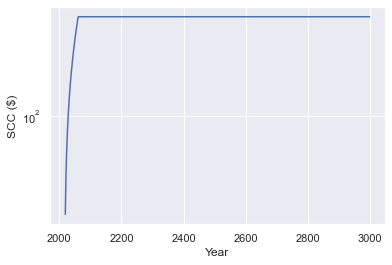

In [18]:
plt.plot(T_forecast_years, SCC_forecasted)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

## 3. Abatement as a function of time

In [19]:
P0 = SCC_forecasted[0]

In [20]:
# P0

In [21]:
forecasted_abatement = abatement(P=SCC_forecasted, P0=P0_prime)  # , r=consumption_discount

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_26597/3467307378.py:50: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


In [22]:
forecasted_abatement

array([0.        , 0.00154832, 0.00499266, 0.00995887, 0.01631917,
       0.02400037, 0.03296403, 0.04317625, 0.05462195, 0.06727822,
       0.08113837, 0.09618171, 0.1124043 , 0.12978384, 0.14831639,
       0.16797614, 0.18875767, 0.21063059, 0.23358716, 0.25759188,
       0.28263425, 0.30867343, 0.33569603, 0.36365595, 0.39253692,
       0.42228784, 0.45288982, 0.48428719, 0.51645878, 0.54934491,
       0.58292259, 0.61712884, 0.65193935, 0.6872886 , 0.72315157,
       0.75946094, 0.79619159, 0.83327525, 0.87068727, 0.90835921,
       0.94626747, 0.98434421, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

problems with certain values due to constraints of the model

In [23]:
((P_100-P0)/(P_50-P0))**(s/r)

2.4554928661051028

Text(0, 0.5, 'Abatement')

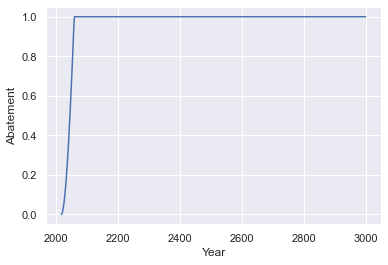

In [24]:
plt.plot(T_forecast_years, forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

In [25]:
ssp_df = pd.read_csv("ssp245.csv", index_col=0)

In [26]:
ssp245_CO2_past = ssp_df["carbon_dioxide"]*(44/12)  

In [27]:
CO2_baseline = ssp245_CO2_past[2019] # set baseline to current emissions

In [28]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

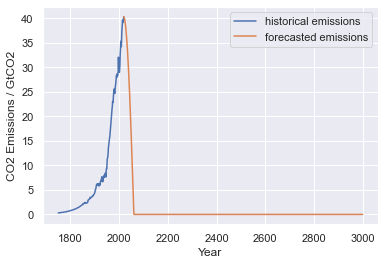

In [29]:
plt.plot(ssp245_CO2_past, label="historical emissions")
plt.plot(T_forecast_years, forecasted_emissions, label="forecasted emissions")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions / GtCO2")
plt.legend()

## 5. Cumulative Emissions to Temperature Change

In [30]:
cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

In [31]:
temperature_change = T_TCRE*cumulative_emissions_array

In [32]:
T_forecast_iteration0 = T_2019 + temperature_change
# T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

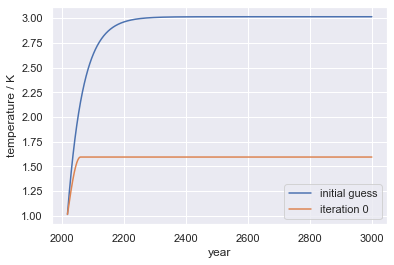

In [33]:
plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_iteration0, label="iteration 0")
# plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("year")
plt.ylabel("temperature / K")
plt.legend()

# Iterating Further

In [34]:
# T_forecast_first_loop = T_forecast_iteration0_plateau
# T_forecast_iteration = T_forecast_iteration0_plateau

In [35]:
T_forecast_first_loop = T_forecast_iteration0
T_forecast_iteration = T_forecast_iteration0

367.73440079194654


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_26597/3467307378.py:50: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1.4932369028552364
377.74099523947064


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_26597/3467307378.py:50: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


1.4862571218648666
378.5003524658261
1.486380879717602
2


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_26597/3467307378.py:50: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


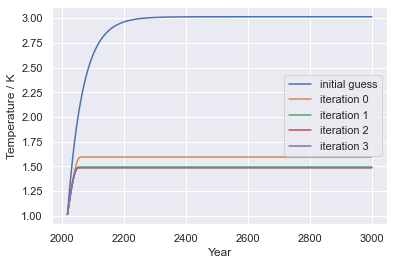

In [36]:
num_of_iterations = 99

first_perturbed_year = last_historical_year

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_first_loop, label="iteration 0")

for k in range(num_of_iterations):
    T_iteration = np.concatenate([T_gas_df['CO2_best'],T_forecast_iteration[1:]])

    SCC_list = []
    SCC_list_actual = []

    for j in range(len(year_of_perturbation)):
        ## define perturbation
        T_TCRE = 0.00054  # need to check this! *100 for 100GtCO2 added
        k_s = 0.12

        T_p = np.zeros(T_forecast_length)

        for i in range(len(T_forecast_years)):
            if year_of_perturbation[j] <= T_forecast_years[i]:
                T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))

        T_forecast_perturbed = T_forecast_iteration+T_p

        T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])

        g = g_2019 - g_grad*(T_forecast_iteration[:-1]-T_2019)**1
        g_prime = g_2019 - g_grad*(T_forecast_perturbed[:-1]-T_2019)**1
        
        growth_adjusted_consumption_discount = g[j] + growth_adjustment
        
        W = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g)
        W_prime = create_W(W_2019, last_historical_year, start_year, T_forecast_years, g_prime)

        ## define discount function
        num_of_years = len(years)

        discount_function = np.zeros(num_of_years)

        for i in range(num_of_years):
            if years[i] >= year_of_perturbation[j]:
                discount_function[i] = np.exp(-growth_adjusted_consumption_discount*(years[i]-year_of_perturbation[j]))

        absolute_consumption_loss = W-W_prime
        discounted_consumption_loss = absolute_consumption_loss*discount_function
        area = simps(discounted_consumption_loss, dx=1)
        cost = area*10**12  # convert to dollar amount
        
        SCC = cost/(10**9)
        SCC_list_actual.append(SCC)
        
#         if SCC < P_100:
#             SCC_list.append(SCC)
#         else:
#             SCC_list.append(P_100)
#             break
        if j == 0 and P0_prime > P_100:
            print("P_100 achieved in first year")
            print(SCC)
        elif j == 0:  #  and SCC > P_100
            P0 = SCC
            print(SCC)
            SCC_list.append(P0_prime)
        else:
            SCC_adjusted = SCC - (P0-P0_prime)
            if SCC_adjusted < P_100:
                SCC_list.append(SCC_adjusted)
        #         print(SCC)
            else:
                SCC_list.append(P_100)
                break

    SCC_array = np.asarray(SCC_list)
    if SCC_array[-1] < P_100:
        print("P_100 not achieved by achieved by final perturbed year")
    SCC_forecasted = []

    for i in range(T_forecast_length):
        if i < len(SCC_array):
            SCC_forecasted.append(SCC_array[i])
        else:
            SCC_forecasted.append(P_100)

    SCC_forecasted = np.array(SCC_forecasted)

    P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(P=SCC_forecasted, P0=P0_prime)  # , r=consumption_discount
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

    cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

    temperature_change = T_TCRE*cumulative_emissions_array
    
    T_forecast_iteration = T_2019 + temperature_change
    
    plt.plot(T_forecast_years, T_forecast_iteration, label="iteration "+str(k+1))
    
    if k == 0:
        peak_T = max(T_forecast_iteration)
        print(peak_T)
    else:
        previous_peak_T = peak_T
        peak_T = max(T_forecast_iteration)
        print(peak_T)
        if abs(peak_T - previous_peak_T) < 0.005:
            print(k)
            break
    
    if k == num_of_iterations - 1:
        print("convergence condition not achieved")
        print(f"{consumption_discount=}")
        print(f"{g_2019=}")
        print(f"{P_50=}")
        print(f"{s=}")
        print(f"{r=}")
        print(f"{P_100=}")

plt.xlabel("Year")
plt.ylabel("Temperature / K")
plt.legend()

In [37]:
P0

20.0

In [38]:
## peak Temperature
max(T_forecast_iteration)

1.486380879717602

In [39]:
SCC_forecasted

array([ 20.        ,  30.05554472,  40.38279897,  50.97574351,
        61.83843715,  72.96532363,  84.36010143,  96.01609243,
       107.93607358, 120.11192429, 132.54531294, 145.22655072,
       158.15614308, 171.32281278, 184.72594134, 198.35272881,
       212.2015531 , 226.25823333, 240.52033545, 254.97250416,
       269.61174283, 284.42177692, 299.39933636, 314.52751133,
       329.80306607, 345.20874656, 360.741656  , 376.3844731 ,
       392.13492166, 407.97585789, 423.90586923, 439.90818878,
       455.98246165, 472.11244438, 488.29898044, 500.        ,
       500.        , 500.        , 500.        , 500.        ,
       500.        , 500.        , 500.        , 500.        ,
       500.        , 500.        , 500.        , 500.        ,
       500.        , 500.        , 500.        , 500.        ,
       500.        , 500.        , 500.        , 500.        ,
       500.        , 500.        , 500.        , 500.        ,
       500.        , 500.        , 500.        , 500.  

In [40]:
SCC_list_actual

[378.5003524658261,
 388.5558971896146,
 398.8831514315333,
 409.4760959743294,
 420.33878961986005,
 431.4656760930748,
 442.8604538941894,
 454.51644489635135,
 466.4364260487982,
 478.61227675191645,
 491.04566540417045,
 503.72690318678525,
 516.6564955427338,
 529.8231652424004,
 543.2262938064165,
 556.8530812771586,
 570.7019055625533,
 584.7585857936559,
 599.0206879131454,
 613.4728566251541,
 628.1120952976552,
 642.922129390365,
 657.8996888229702,
 673.027863793621,
 688.3034185353329,
 703.7090990306069,
 719.2420084705382,
 734.8848255680145,
 750.635274121936,
 766.4762103564726,
 782.4062216996045,
 798.4085412438982,
 814.4828141142785,
 830.6127968456165,
 846.7993329028924,
 863.0267941548237]

hard constraint on absolute reduction that can be achieved in one year

2.013549671765545

- max ~2GtCO2 in year (look in IAMs)
- directions MACC non...
- comment on efficiency
- equation on flowchart
- balance between forcing log and errors
- gradient MACC
- table for Sobol
- peak warming and year of peak warming; scatter with growth rate